In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from causal_cocycle.kernels_new import GaussianKernel, median_heuristic, median_heuristic_ard
from causal_cocycle.helper_functions import mmd

## KR cocycle estimation

tensor(0.6513, dtype=torch.float64)


/tmp/ipykernel_501552/2870385616.py:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel = GaussianKernel(lengthscale=torch.tensor(ls_best))


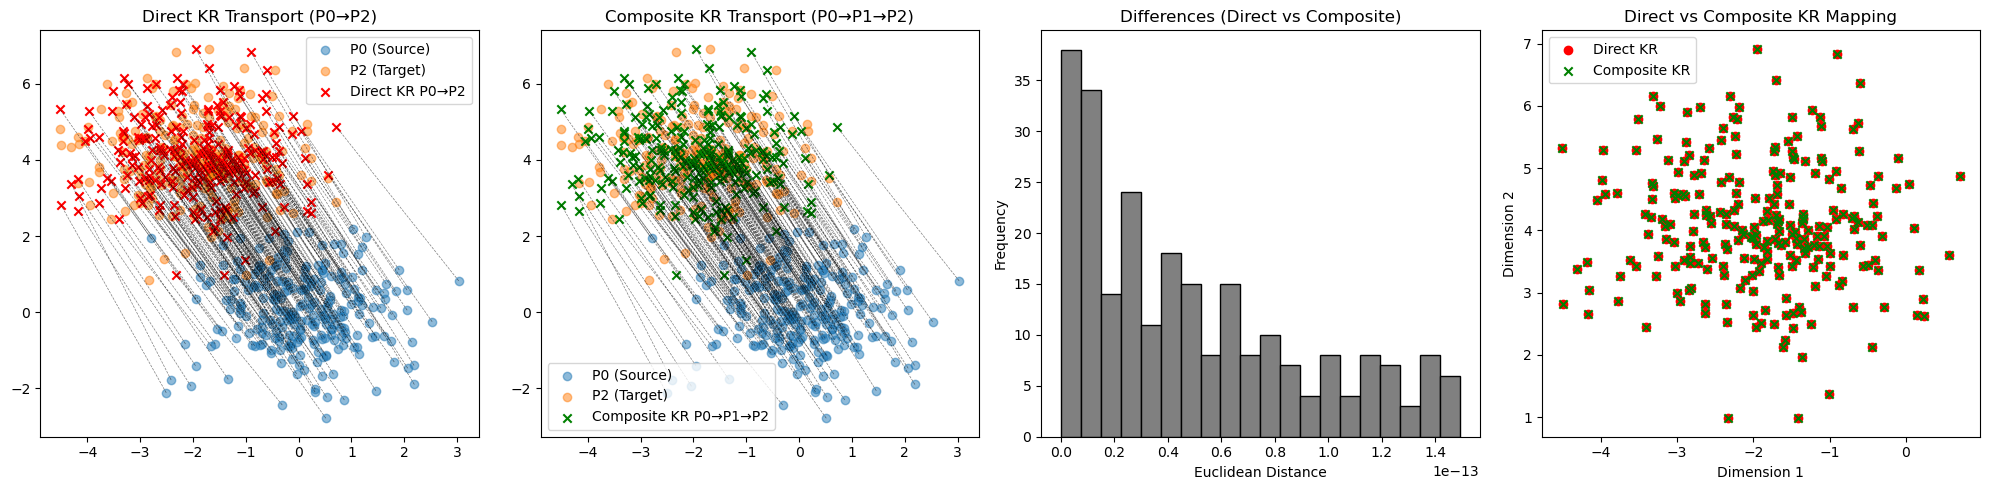

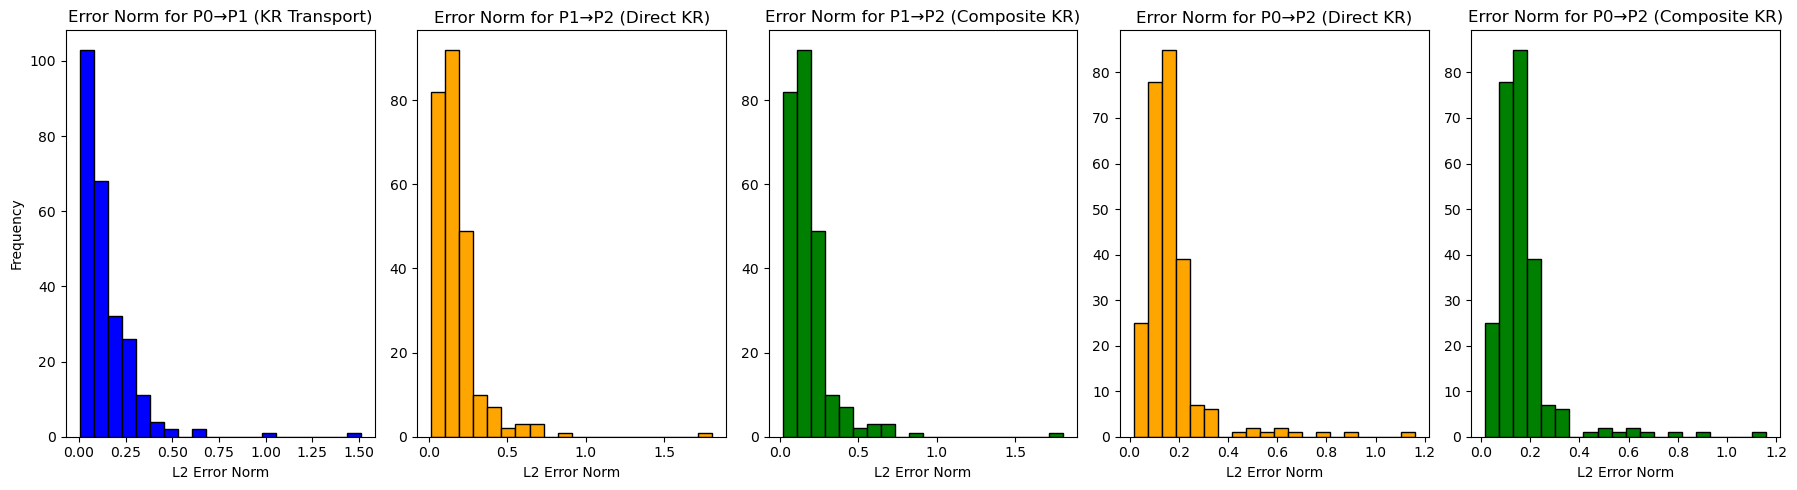

Average error norm for P0→P1 (KR Transport): 0.14156831495639147
Average error norm for P1→P2 (Direct KR): 0.17660524166622327
Average error norm for P1→P2 (Composite KR): 0.17660524166622193
Average error norm for P0→P2 (Direct KR): 0.16763505984241675
Average error norm for P0→P2 (Composite KR): 0.1676350598424175
Counterfactual inconsistency (RMSE): tensor(4.5504e-14, dtype=torch.float64)
CMMD :  tensor(0.0236, dtype=torch.float64, grad_fn=<AddBackward0>)


In [7]:
# Set seed for reproducibility
np.random.seed(1)

# Define numbers of samples and dimension
n=250
n0 = n  # number of points in P0
n1 = 250  # number of points in P1
n2 = n  # number of points in P2
dim = 2

# Generate synthetic data for three distributions
P0 = np.random.randn(n0, dim)                  # P0: standard normal
P1 = np.random.randn(n1, dim) + np.array([3, 3])# P1: shifted by (3,3)
P2 = np.random.randn(n2, dim)+ np.array([-2, 4])# P2: shifted by (-2,4)

ls_best = median_heuristic(torch.tensor(P0)[:,:1])
print(ls_best)

# ----------------------------
# Helper functions (assumed defined)
# ----------------------------

def compute_weights_from_kernel(kernel, X1, x1_query):
    """
    Returns normalized weights w_i(x1_query) using kernel.get_gram().
    X1 is a 1D tensor of training values.
    x1_query is a scalar (or 0D tensor).
    """
    if x1_query.dim() == 0:
        x1_query = x1_query.view(1, 1)
    elif x1_query.dim() == 1:
        x1_query = x1_query.unsqueeze(0)
    if X1.dim() == 1:
        X1 = X1.unsqueeze(1)
    K_vals = kernel.get_gram(x1_query, X1).flatten()
    return K_vals / K_vals.sum()

# Modified KR transport (1D) with provided weights
def build_KR_map(X: torch.Tensor, Y: torch.Tensor, 
                                                   w_src: torch.Tensor = None, w_tgt: torch.Tensor = None, epsilon: float = 1e-8):

    # Get weights if not provided
    if w_src is None:
        n_src = X.numel()
        w_src = torch.ones(n_src, device=X.device) / n_src
    if w_tgt is None:
        n_tgt = Y.numel()
        w_tgt = torch.ones(n_tgt, device=Y.device) / n_tgt
    
    # Sort X and Y first
    X_sorted_full, idx_X = torch.sort(X)
    Y_sorted_full, idx_Y = torch.sort(Y)
    w_src_sorted_full = w_src[idx_X]
    w_tgt_sorted_full = w_tgt[idx_Y]
    
    # Get unique sorted values for X, and sum the weights of duplicates.
    X_sorted, inverse_idx_X = torch.unique(X_sorted_full, sorted=True, return_inverse=True)
    w_src_sorted = torch.zeros_like(X_sorted, dtype=w_src.dtype)
    w_src_sorted = w_src_sorted.scatter_add_(0, inverse_idx_X, w_src_sorted_full)
    
    # Do the same for Y.
    Y_sorted, inverse_idx_Y = torch.unique(Y_sorted_full, sorted=True, return_inverse=True)
    w_tgt_sorted = torch.zeros_like(Y_sorted, dtype=w_tgt.dtype)
    w_tgt_sorted = w_tgt_sorted.scatter_add_(0, inverse_idx_Y, w_tgt_sorted_full)
    
    # Normalize the weights.
    w_src_sorted = w_src_sorted / w_src_sorted.sum()
    w_tgt_sorted = w_tgt_sorted / w_tgt_sorted.sum()
    
    def S(z):
        z = z.double()
        if epsilon == 0:
            return (z>=0).float()
        else:
            return torch.where(z < -epsilon, torch.zeros_like(z),
                               torch.where(z > epsilon, torch.ones_like(z),
                                           (z + epsilon) / (2 * epsilon)))
    def F_src(y):
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, device=X_sorted.device)
        if y.dim() == 0:
            y = y.unsqueeze(0)
        if y.dim() == 1:
            y = y.unsqueeze(1)
        X_exp = X_sorted.unsqueeze(0)
        S_vals = S(y - X_exp)
        return torch.sum(w_src_sorted * S_vals, dim=-1)
        
    def Q_tgt(t):
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, device=Y_sorted.device)
        if t.dim() > 1:
            t = t.squeeze(-1)
        cumsum = torch.cumsum(w_tgt_sorted, dim=0)
        indices = torch.searchsorted(cumsum, t.unsqueeze(1)).squeeze(1)
        indices = torch.clamp(indices, 0, Y_sorted.numel()-1)
        j = indices-1
        j_next = indices
        cumsum = torch.concatenate((torch.zeros(1),cumsum))
        cumsum_j = cumsum[j+1]
        w_j_next = w_tgt_sorted[j_next]
        s = (t - cumsum_j) / w_j_next
        Y_j_next = Y_sorted[j_next].double()
        Y_prev = Y_sorted[torch.clamp(j, min=0)].double()
        return Y_j_next - epsilon + 2 * epsilon * s
        
    def KR(y):
        t_val = F_src(y)
        return Q_tgt(t_val)
    return KR

# ----------------------------
# End-to-end KR transport procedure
# ----------------------------

# Convert to torch tensors
Y0 = torch.tensor(P0, dtype=torch.float64)
Y1 = torch.tensor(P1, dtype=torch.float64)
Y2 = torch.tensor(P2, dtype=torch.float64)

# Sorting data
idx0 = torch.argsort(Y0[:,1])
idx1 = torch.argsort(Y1[:,1])
idx2 = torch.argsort(Y2[:,1])

Y0 = Y0[idx0]
Y1 = Y1[idx1]
Y2 = Y2[idx2]

# ----------------------------
# KR transport for the first dimension (1D maps
epsilon = 1e-8

# Use uniform weights here (empirical CDF)
KR10 = build_KR_map(Y0[:,0], Y1[:,0], epsilon=epsilon)
KR21 = build_KR_map(Y1[:,0], Y2[:,0], epsilon=epsilon)
KR20 = build_KR_map(Y0[:,0], Y2[:,0], epsilon=epsilon)

Yhat1 = KR10(Y0[:,0])           # Transport P0 -> P1, first coordinate
Yhat2_direct = KR20(Y0[:,0])      # Direct transport P0 -> P2, first coordinate
Yhat2_composite = KR21(Yhat1)     # Composite transport P0 -> P1 -> P2, first coordinate

# ----------------------------
# For the second dimension we use the weighted KR transport.
# We'll set a small epsilon (e.g., 1e-8) for the smoothing function.
kernel = GaussianKernel(lengthscale=torch.tensor(ls_best))

mapped_second_direct = []
mapped_second_composite = []
mapped_second_1 = []

# For each sample in P0, compute the conditional KR transport for the second dimension.
for i in range(Y0.shape[0]):
    # Extract source coordinates from P0:
    x1_0 = Y0[i, 0]
    x2_0 = Y0[i, 1]
    X2 = Y0[:, 1]  # second coordinates of P0
    
    # Compute source conditional weights from the first coordinate using uniform (empirical) weighting
    # For the conditional KR on the second dimension for P0 -> P1:
    w_src = compute_weights_from_kernel(kernel, Y0[:,0], x1_0)
    
    # ----- For P0 -> P1 (for the second coordinate) -----
    # Compute target conditional weights using the first-coordinate mapping from P0->P1
    w_tgt_1 = compute_weights_from_kernel(kernel, Y1[:,0], KR10(x1_0))
    Y1_2 = Y1[:,1]
    KR_2_1 = build_KR_map(X2, Y1_2, w_src, w_tgt_1, epsilon)
    mapped_second_1.append(KR_2_1(x2_0).item())
    
    # ----- For direct P0 -> P2 -----
    w_tgt_direct = compute_weights_from_kernel(kernel, Y2[:,0], KR20(x1_0))
    Y2_direct = Y2[:,1]
    KR_2_direct = build_KR_map(X2, Y2_direct, w_src, w_tgt_direct, epsilon)
    mapped_second_direct.append(KR_2_direct(x2_0).item())
    
    # ----- For composite transport P0 -> P1 -> P2 -----
    # Use the first-dim composite mapping: x1_hat from Yhat1 (which is P0 -> P1)
    x1_hat = Yhat1[i]
    w_tgt_composite = compute_weights_from_kernel(kernel, Y2[:,0], KR21(x1_hat))
    KR_2_composite = build_KR_map(X2, Y2[:,1], w_src, w_tgt_composite, epsilon)
    mapped_second_composite.append(KR_2_composite(x2_0).item())

mapped_second_1 = torch.tensor(mapped_second_1)
mapped_second_direct = torch.tensor(mapped_second_direct)
mapped_second_composite = torch.tensor(mapped_second_composite)

# Construct full 2D transported points:
Yhat1_2d = torch.stack([Yhat1, mapped_second_1], dim=1)
Yhat2_direct_2d = torch.stack([Yhat2_direct, mapped_second_direct], dim=1)
Yhat2_composite_2d = torch.stack([Yhat2_composite, mapped_second_composite], dim=1)

# ----------------------------
# Now, plot the results (similar to the OT plots)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: Direct KR Transport (P0 -> P2) with connecting lines from source to transport
axes[0].scatter(Y0[:,0], Y0[:,1], label='P0 (Source)', alpha=0.5)
axes[0].scatter(Y2[:,0], Y2[:,1], label='P2 (Target)', alpha=0.5)
axes[0].scatter(Yhat2_direct_2d[:,0], Yhat2_direct_2d[:,1], marker='x', color='red', label='Direct KR P0→P2')
for i in range(n0):
    axes[0].plot([Y0[i,0], Yhat2_direct_2d[i,0]], [Y0[i,1], Yhat2_direct_2d[i,1]], 'k--', linewidth=0.5, alpha=0.5)
axes[0].set_title('Direct KR Transport (P0→P2)')
axes[0].legend()

# Plot 2: Composite KR Transport (P0 -> P1 -> P2) with connecting lines from source to transport
axes[1].scatter(Y0[:,0], Y0[:,1], label='P0 (Source)', alpha=0.5)
axes[1].scatter(Y2[:,0], Y2[:,1], label='P2 (Target)', alpha=0.5)
axes[1].scatter(Yhat2_composite_2d[:,0], Yhat2_composite_2d[:,1], marker='x', color='green', label='Composite KR P0→P1→P2')
for i in range(n0):
    axes[1].plot([Y0[i,0], Yhat2_composite_2d[i,0]], [Y0[i,1], Yhat2_composite_2d[i,1]], 'k--', linewidth=0.5, alpha=0.5)
axes[1].set_title('Composite KR Transport (P0→P1→P2)')
axes[1].legend()

# Plot 3: Histogram of distances between direct and composite KR transports
distances_KR = torch.norm(Yhat2_direct_2d - Yhat2_composite_2d, dim=1).numpy()
axes[2].hist(distances_KR, bins=20, color='gray', edgecolor='black')
axes[2].set_title('Differences (Direct vs Composite)')
axes[2].set_xlabel('Euclidean Distance')
axes[2].set_ylabel('Frequency')

# Plot 4: Overlay of Direct vs Composite KR transports with connecting lines
axes[3].scatter(Yhat2_direct_2d[:,0], Yhat2_direct_2d[:,1], color='red', label='Direct KR', marker='o')
axes[3].scatter(Yhat2_composite_2d[:,0], Yhat2_composite_2d[:,1], color='green', label='Composite KR', marker='x')
for i in range(n0):
    axes[3].plot([Yhat2_direct_2d[i,0], Yhat2_composite_2d[i,0]], [Yhat2_direct_2d[i,1], Yhat2_composite_2d[i,1]], 'k--', linewidth=1.0)
axes[3].set_title('Direct vs Composite KR Mapping')
axes[3].set_xlabel('Dimension 1')
axes[3].set_ylabel('Dimension 2')
axes[3].legend()

plt.tight_layout()
plt.show()

# ----------------------------
# Compute error statistics relative to the true shifts

# True shifts:
true_shift_01 = np.array([3, 3])      # P0 -> P1
true_shift_21 = np.array([-5, 1])       # P1 -> P2
true_shift_20 = true_shift_21 + true_shift_01      # P1 -> P2

# Compute error for P0 -> P1:
# Estimated shift for P0 -> P1 (full 2D) is Yhat1_2d - Y0.
delta_01 = (Yhat1_2d - Y0).numpy()     # shape: (n, 2)
error_01 = delta_01 - true_shift_01      # error compared to [3, 3]
norm_error_01 = np.linalg.norm(error_01, axis=1)  # L2 norm per sample

# Compute error for P1 -> P2:
# For the direct KR transport, the estimated shift is (Yhat2_direct_2d - Yhat1_2d)
delta_21_direct = (Yhat2_direct_2d - Yhat1_2d).numpy()
error_21_direct = delta_21_direct - true_shift_21
norm_error_21_direct = np.linalg.norm(error_21_direct, axis=1)

# For the composite KR transport, the estimated shift is (Yhat2_composite_2d - Yhat1_2d)
delta_21_composite = (Yhat2_composite_2d - Yhat1_2d).numpy()
error_21_composite = delta_21_composite - true_shift_21
norm_error_21_composite = np.linalg.norm(error_21_composite, axis=1)

# Compute error for P1 -> P2:
# For the direct KR transport, the estimated shift is (Yhat2_direct_2d - Yhat1_2d)
delta_20_direct = (Yhat2_direct_2d - Y0).numpy()
error_20_direct = delta_20_direct - true_shift_20
norm_error_20_direct = np.linalg.norm(error_20_direct, axis=1)

# For the composite KR transport, the estimated shift is (Yhat2_composite_2d - Yhat1_2d)
delta_20_composite = (Yhat2_composite_2d - Y0).numpy()
error_20_composite = delta_20_composite - true_shift_20
norm_error_20_composite = np.linalg.norm(error_20_composite, axis=1)

# ----------------------------
# Plot error norm histograms for all three cases
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Error norm for P0 → P1
axes[0].hist(norm_error_01, bins=20, color='blue', edgecolor='black')
axes[0].set_title('Error Norm for P0→P1 (KR Transport)')
axes[0].set_xlabel('L2 Error Norm')
axes[0].set_ylabel('Frequency')

# Error norm for P1 → P2 (Direct KR)
axes[1].hist(norm_error_21_direct, bins=20, color='orange', edgecolor='black')
axes[1].set_title('Error Norm for P1→P2 (Direct KR)')
axes[1].set_xlabel('L2 Error Norm')

# Error norm for P1 → P2 (Composite KR)
axes[2].hist(norm_error_21_composite, bins=20, color='green', edgecolor='black')
axes[2].set_title('Error Norm for P1→P2 (Composite KR)')
axes[2].set_xlabel('L2 Error Norm')

# Error norm for P0 → P2 (Direct KR)
axes[3].hist(norm_error_20_direct, bins=20, color='orange', edgecolor='black')
axes[3].set_title('Error Norm for P0→P2 (Direct KR)')
axes[3].set_xlabel('L2 Error Norm')

# Error norm for P0 → P2 (Composite KR)
axes[4].hist(norm_error_20_composite, bins=20, color='green', edgecolor='black')
axes[4].set_title('Error Norm for P0→P2 (Composite KR)')
axes[4].set_xlabel('L2 Error Norm')

plt.tight_layout()
plt.show()

# ----------------------------
# Print average error norms
print("Average error norm for P0→P1 (KR Transport):", np.mean(norm_error_01))
print("Average error norm for P1→P2 (Direct KR):", np.mean(norm_error_21_direct))
print("Average error norm for P1→P2 (Composite KR):", np.mean(norm_error_21_composite))
print("Average error norm for P0→P2 (Direct KR):", np.mean(norm_error_20_direct))
print("Average error norm for P0→P2 (Composite KR):", np.mean(norm_error_20_composite))
print("Counterfactual inconsistency (RMSE):", ((Yhat2_direct_2d-Yhat2_composite_2d)**2).mean()**0.5)

# MMD construction
cmmd = 0
MMD = mmd(GaussianKernel(lengthscale = torch.ones(2)/2**0.5))
cmmd += MMD(Yhat1_2d, Y1, median_heuristic = False)*n1/(n1+n2)
cmmd += MMD(Yhat2_direct_2d,Y2, median_heuristic = False)*n2/(n1+n2)
print("CMMD : ", cmmd)

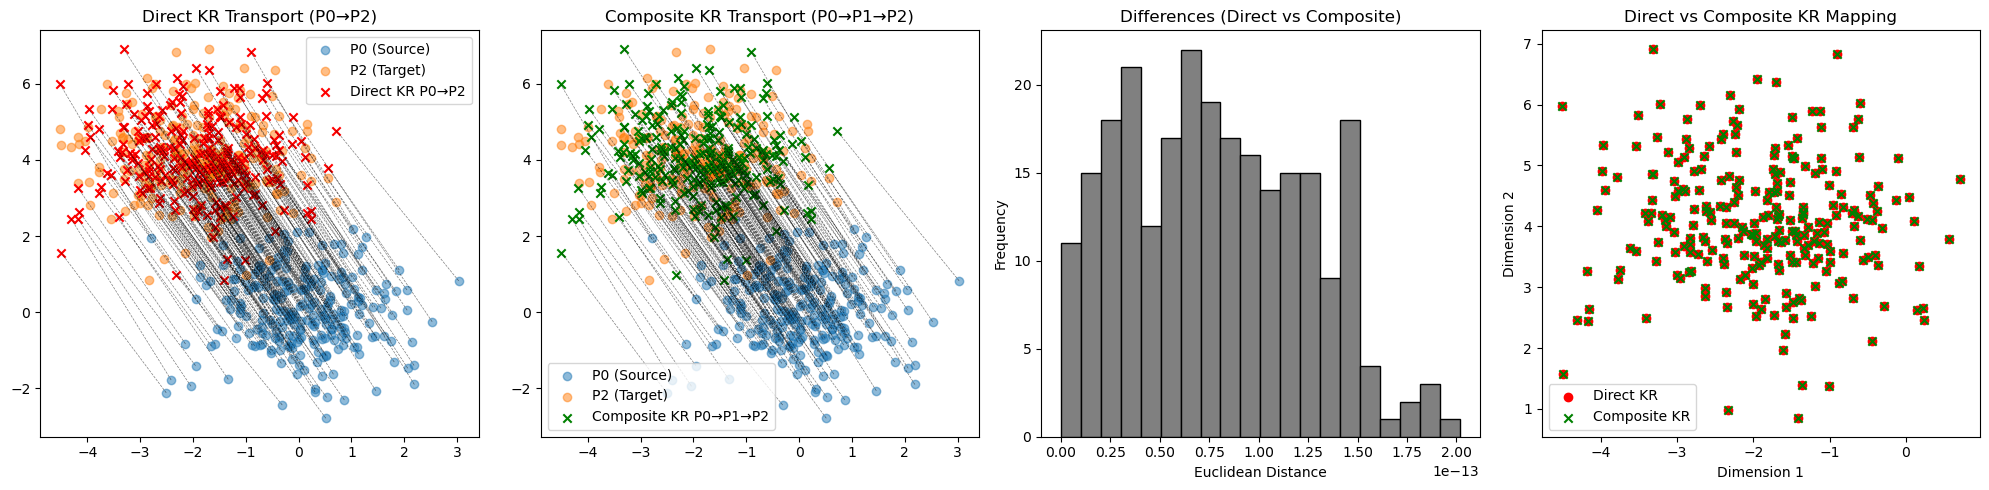

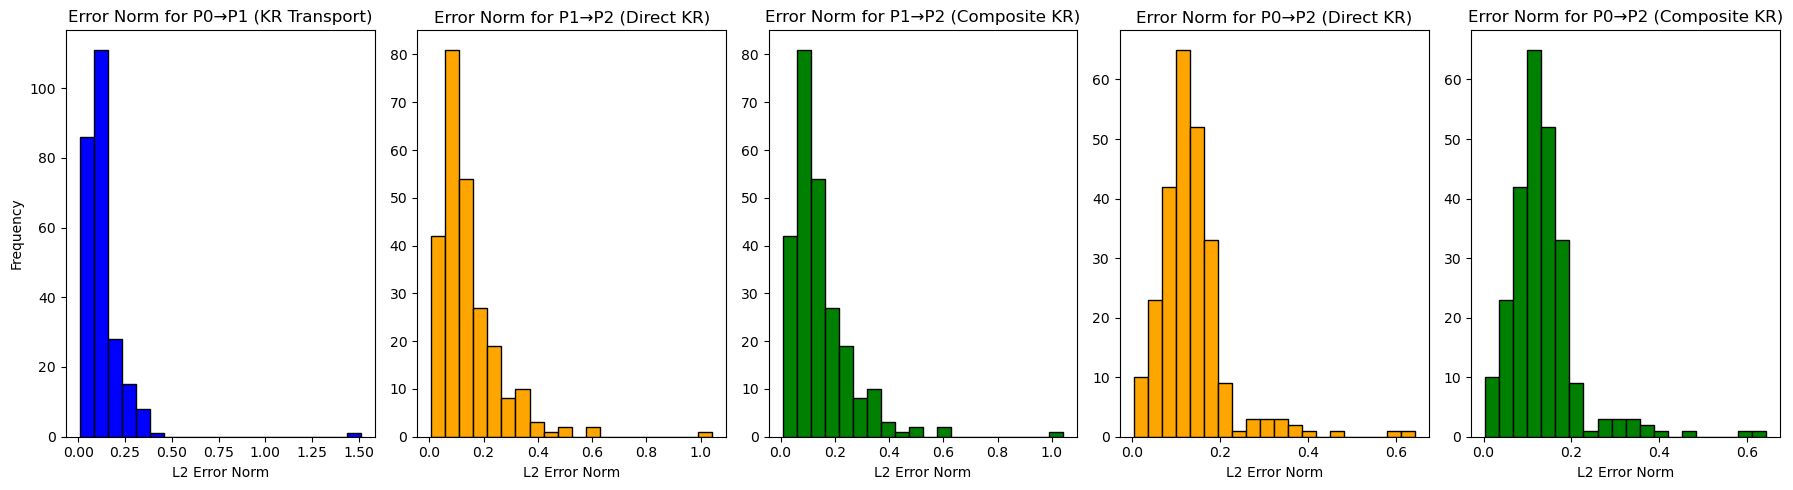

Average error norm for P0→P1 (KR Transport): 0.12200484837047196
Average error norm for P1→P2 (Direct KR): 0.14318931004536467
Average error norm for P1→P2 (Composite KR): 0.1431893100453629
Average error norm for P0→P2 (Direct KR): 0.13499623810559944
Average error norm for P0→P2 (Composite KR): 0.13499623810560205
Counterfactual inconsistency (RMSE): tensor(6.4359e-14, dtype=torch.float64)
CMMD :  tensor(0.0401, dtype=torch.float64, grad_fn=<AddBackward0>)


In [9]:
# Set seed for reproducibility
np.random.seed(1)


# ----------------------------
# End-to-end KR transport procedure (factorized)
# ----------------------------

# ----------------------------
# KR transport for the first dimension (1D maps
epsilon = 1e-8

# Use uniform weights here (empirical CDF)
KR10 = build_KR_map(Y0[:,0], Y1[:,0], epsilon=epsilon)
KR21 = build_KR_map(Y1[:,0], Y2[:,0], epsilon=epsilon)
KR20 = build_KR_map(Y0[:,0], Y2[:,0], epsilon=epsilon)

Yhat1 = KR10(Y0[:,0])           # Transport P0 -> P1, first coordinate
Yhat2_direct = KR20(Y0[:,0])      # Direct transport P0 -> P2, first coordinate
Yhat2_composite = KR21(Yhat1)     # Composite transport P0 -> P1 -> P2, first coordinate


# ----------------------------
# KR transport for the second dimension (1D maps

# Use uniform weights here (empirical CDF)
KR10 = build_KR_map(Y0[:,1], Y1[:,1], epsilon=epsilon)
KR21 = build_KR_map(Y1[:,1], Y2[:,1], epsilon=epsilon)
KR20 = build_KR_map(Y0[:,1], Y2[:,1], epsilon=epsilon)

Yhat1_second = KR10(Y0[:,1])           # Transport P0 -> P1, first coordinate
Yhat2_second_direct = KR20(Y0[:,1])      # Direct transport P0 -> P2, first coordinate
Yhat2_second_composite = KR21(Yhat1_second)     # Composite transport P0 -> P1 -> P2, first coordinate

# Construct full 2D transported points:
Yhat1_2d = torch.stack([Yhat1, Yhat1_second], dim=1)
Yhat2_direct_2d = torch.stack([Yhat2_direct, Yhat2_second_direct], dim=1)
Yhat2_composite_2d = torch.stack([Yhat2_composite, Yhat2_second_composite], dim=1)

# ----------------------------
# Now, plot the results (similar to the OT plots)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: Direct KR Transport (P0 -> P2) with connecting lines from source to transport
axes[0].scatter(Y0[:,0], Y0[:,1], label='P0 (Source)', alpha=0.5)
axes[0].scatter(Y2[:,0], Y2[:,1], label='P2 (Target)', alpha=0.5)
axes[0].scatter(Yhat2_direct_2d[:,0], Yhat2_direct_2d[:,1], marker='x', color='red', label='Direct KR P0→P2')
for i in range(n0):
    axes[0].plot([Y0[i,0], Yhat2_direct_2d[i,0]], [Y0[i,1], Yhat2_direct_2d[i,1]], 'k--', linewidth=0.5, alpha=0.5)
axes[0].set_title('Direct KR Transport (P0→P2)')
axes[0].legend()

# Plot 2: Composite KR Transport (P0 -> P1 -> P2) with connecting lines from source to transport
axes[1].scatter(Y0[:,0], Y0[:,1], label='P0 (Source)', alpha=0.5)
axes[1].scatter(Y2[:,0], Y2[:,1], label='P2 (Target)', alpha=0.5)
axes[1].scatter(Yhat2_composite_2d[:,0], Yhat2_composite_2d[:,1], marker='x', color='green', label='Composite KR P0→P1→P2')
for i in range(n0):
    axes[1].plot([Y0[i,0], Yhat2_composite_2d[i,0]], [Y0[i,1], Yhat2_composite_2d[i,1]], 'k--', linewidth=0.5, alpha=0.5)
axes[1].set_title('Composite KR Transport (P0→P1→P2)')
axes[1].legend()

# Plot 3: Histogram of distances between direct and composite KR transports
distances_KR = torch.norm(Yhat2_direct_2d - Yhat2_composite_2d, dim=1).numpy()
axes[2].hist(distances_KR, bins=20, color='gray', edgecolor='black')
axes[2].set_title('Differences (Direct vs Composite)')
axes[2].set_xlabel('Euclidean Distance')
axes[2].set_ylabel('Frequency')

# Plot 4: Overlay of Direct vs Composite KR transports with connecting lines
axes[3].scatter(Yhat2_direct_2d[:,0], Yhat2_direct_2d[:,1], color='red', label='Direct KR', marker='o')
axes[3].scatter(Yhat2_composite_2d[:,0], Yhat2_composite_2d[:,1], color='green', label='Composite KR', marker='x')
for i in range(n0):
    axes[3].plot([Yhat2_direct_2d[i,0], Yhat2_composite_2d[i,0]], [Yhat2_direct_2d[i,1], Yhat2_composite_2d[i,1]], 'k--', linewidth=1.0)
axes[3].set_title('Direct vs Composite KR Mapping')
axes[3].set_xlabel('Dimension 1')
axes[3].set_ylabel('Dimension 2')
axes[3].legend()

plt.tight_layout()
plt.show()

# ----------------------------
# Compute error statistics relative to the true shifts

# True shifts:
true_shift_01 = np.array([3, 3])      # P0 -> P1
true_shift_21 = np.array([-5, 1])       # P1 -> P2
true_shift_20 = true_shift_21 + true_shift_01      # P1 -> P2

# Compute error for P0 -> P1:
# Estimated shift for P0 -> P1 (full 2D) is Yhat1_2d - Y0.
delta_01 = (Yhat1_2d - Y0).numpy()     # shape: (n, 2)
error_01 = delta_01 - true_shift_01      # error compared to [3, 3]
norm_error_01 = np.linalg.norm(error_01, axis=1)  # L2 norm per sample

# Compute error for P1 -> P2:
# For the direct KR transport, the estimated shift is (Yhat2_direct_2d - Yhat1_2d)
delta_21_direct = (Yhat2_direct_2d - Yhat1_2d).numpy()
error_21_direct = delta_21_direct - true_shift_21
norm_error_21_direct = np.linalg.norm(error_21_direct, axis=1)

# For the composite KR transport, the estimated shift is (Yhat2_composite_2d - Yhat1_2d)
delta_21_composite = (Yhat2_composite_2d - Yhat1_2d).numpy()
error_21_composite = delta_21_composite - true_shift_21
norm_error_21_composite = np.linalg.norm(error_21_composite, axis=1)

# Compute error for P1 -> P2:
# For the direct KR transport, the estimated shift is (Yhat2_direct_2d - Yhat1_2d)
delta_20_direct = (Yhat2_direct_2d - Y0).numpy()
error_20_direct = delta_20_direct - true_shift_20
norm_error_20_direct = np.linalg.norm(error_20_direct, axis=1)

# For the composite KR transport, the estimated shift is (Yhat2_composite_2d - Yhat1_2d)
delta_20_composite = (Yhat2_composite_2d - Y0).numpy()
error_20_composite = delta_20_composite - true_shift_20
norm_error_20_composite = np.linalg.norm(error_20_composite, axis=1)

# ----------------------------
# Plot error norm histograms for all three cases
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Error norm for P0 → P1
axes[0].hist(norm_error_01, bins=20, color='blue', edgecolor='black')
axes[0].set_title('Error Norm for P0→P1 (KR Transport)')
axes[0].set_xlabel('L2 Error Norm')
axes[0].set_ylabel('Frequency')

# Error norm for P1 → P2 (Direct KR)
axes[1].hist(norm_error_21_direct, bins=20, color='orange', edgecolor='black')
axes[1].set_title('Error Norm for P1→P2 (Direct KR)')
axes[1].set_xlabel('L2 Error Norm')

# Error norm for P1 → P2 (Composite KR)
axes[2].hist(norm_error_21_composite, bins=20, color='green', edgecolor='black')
axes[2].set_title('Error Norm for P1→P2 (Composite KR)')
axes[2].set_xlabel('L2 Error Norm')

# Error norm for P0 → P2 (Direct KR)
axes[3].hist(norm_error_20_direct, bins=20, color='orange', edgecolor='black')
axes[3].set_title('Error Norm for P0→P2 (Direct KR)')
axes[3].set_xlabel('L2 Error Norm')

# Error norm for P0 → P2 (Composite KR)
axes[4].hist(norm_error_20_composite, bins=20, color='green', edgecolor='black')
axes[4].set_title('Error Norm for P0→P2 (Composite KR)')
axes[4].set_xlabel('L2 Error Norm')

plt.tight_layout()
plt.show()

# ----------------------------
# Print average error norms
print("Average error norm for P0→P1 (KR Transport):", np.mean(norm_error_01))
print("Average error norm for P1→P2 (Direct KR):", np.mean(norm_error_21_direct))
print("Average error norm for P1→P2 (Composite KR):", np.mean(norm_error_21_composite))
print("Average error norm for P0→P2 (Direct KR):", np.mean(norm_error_20_direct))
print("Average error norm for P0→P2 (Composite KR):", np.mean(norm_error_20_composite))
print("Counterfactual inconsistency (RMSE):", ((Yhat2_direct_2d-Yhat2_composite_2d)**2).mean()**0.5)

# MMD construction
cmmd = 0
MMD = mmd(GaussianKernel(lengthscale = torch.ones(2)/2**0.5))
cmmd += MMD(Yhat1_2d, Y1, median_heuristic = False)*n1/(n1+n2)
cmmd += MMD(Yhat2_direct_2d,Y2, median_heuristic = False)*n2/(n1+n2)
print("CMMD : ", cmmd)

/tmp/ipykernel_501552/1629464227.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  kernel = GaussianKernel(lengthscale=torch.tensor(ls_best))


Epsilon :  1e-06


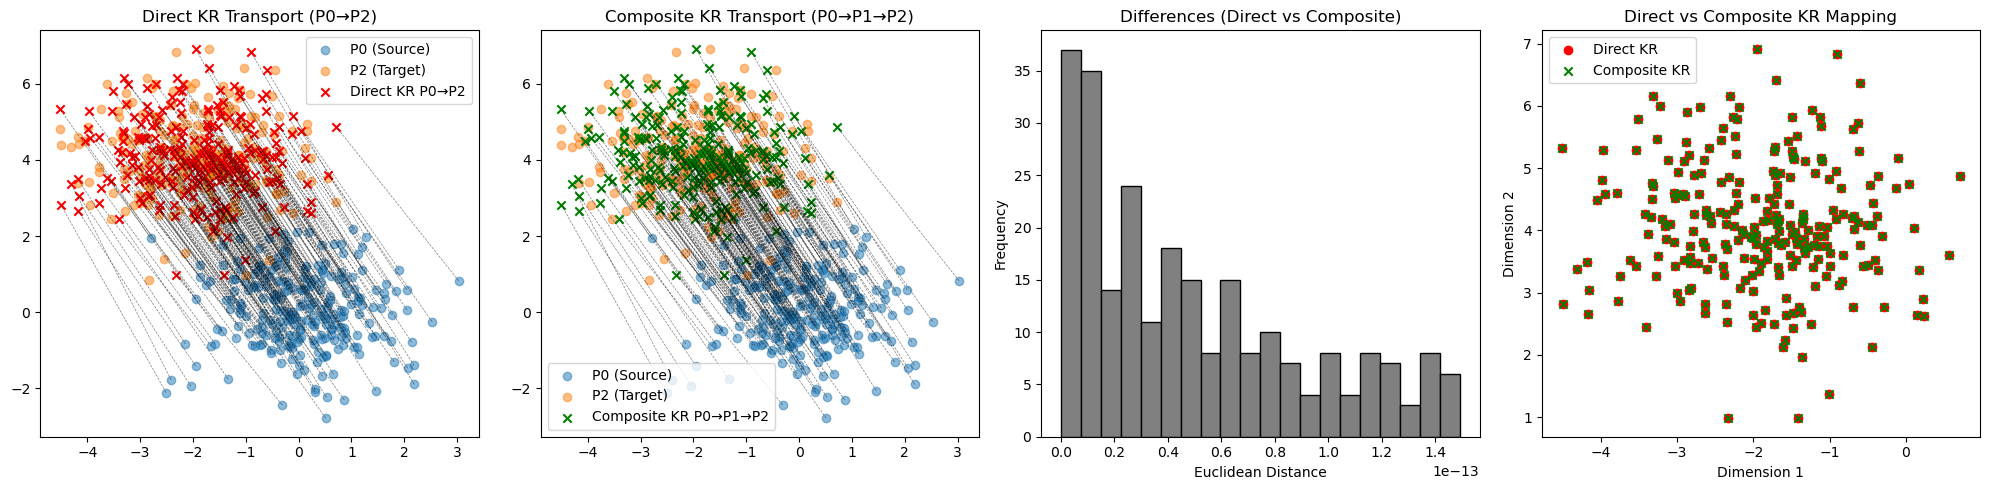

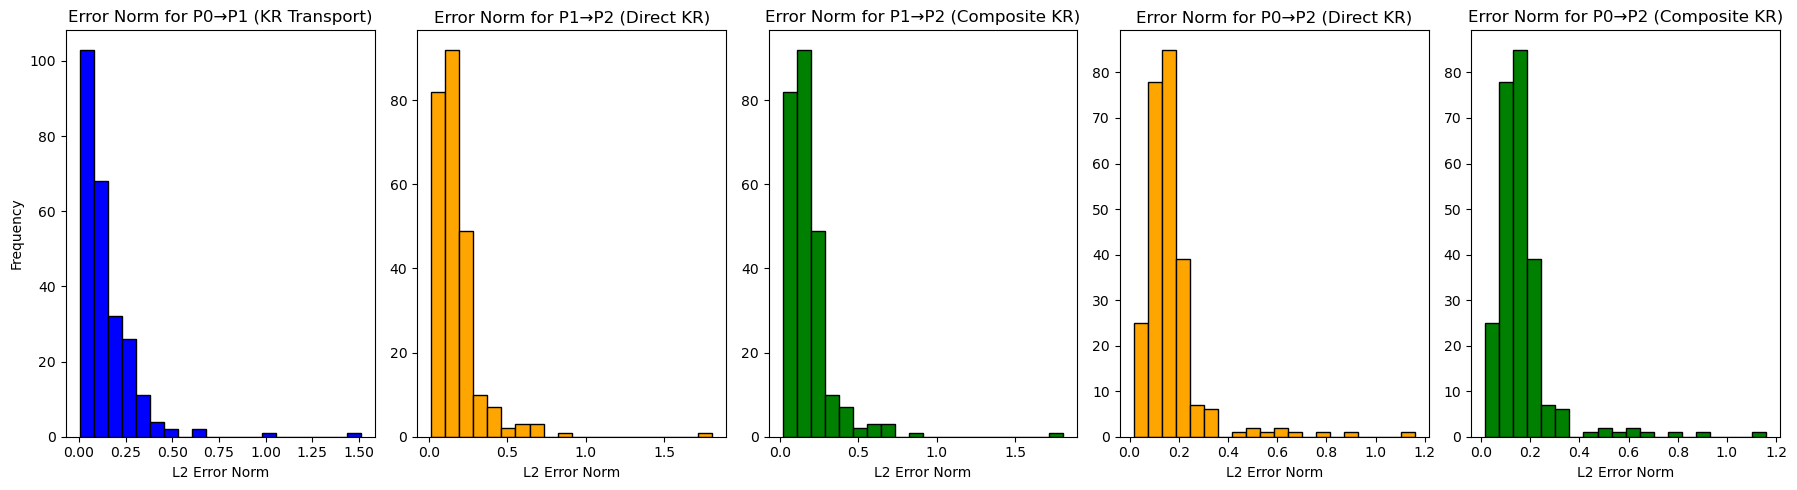

Average error norm for P0→P1 (KR Transport): 0.1415682694992962
Average error norm for P1→P2 (Direct KR): 0.17660519853823292
Average error norm for P1→P2 (Composite KR): 0.17660519853823148
Average error norm for P0→P2 (Direct KR): 0.16763500663558323
Average error norm for P0→P2 (Composite KR): 0.16763500663558392
Counterfactual inconsistency (RMSE): tensor(4.5508e-14, dtype=torch.float64)


In [11]:
"""
CURRENT ISSUE IS MOST LIKELY THE SORTING!
"""

import torch
import numpy as np
from causal_cocycle.kernels_new import GaussianKernel
from causal_cocycle.conditioners_new import NWConditioner
from causal_cocycle.transformers_new import KREpsLayer
from causal_cocycle.model_new import CocycleModel

# Use previously computed kernel lengthscale (assumed learned)
kernel = GaussianKernel(lengthscale=torch.tensor(ls_best))

# Sorting data
idx0 = np.argsort(P0[:, 1])
idx1 = np.argsort(P1[:, 1])
idx2 = np.argsort(P2[:, 1])

# Extract dimension 1 (for conditioning) and dimension 2 (to transport)
X0_1d = Y0[:, 0].unsqueeze(-1)
X1_1d = Y1[:, 0].unsqueeze(-1)
X2_1d = Y2[:, 0].unsqueeze(-1)

Y0_2d = Y0[:, 1].unsqueeze(-1)
Y1_2d = Y1[:, 1].unsqueeze(-1)
Y2_2d = Y2[:, 1].unsqueeze(-1)

# Concatenate inputs
X_all = torch.cat([X0_1d, X1_1d, X2_1d], dim=0).double()
Y_all = torch.cat([Y0_2d, Y1_2d, Y2_2d], dim=0).double()
D_all = torch.cat([
    torch.full((X0_1d.shape[0],), 0, dtype=torch.long),
    torch.full((X1_1d.shape[0],), 1, dtype=torch.long),
    torch.full((X2_1d.shape[0],), 2, dtype=torch.long)
])

# Build a mapping from each D=0,1,2 to corresponding (X,Y)
split_indices = [D_all == d for d in range(3)]
X_splits = [X_all[idx] for idx in split_indices]
Y_splits = [Y_all[idx] for idx in split_indices]

# ---------------------------
# Define a dynamic conditioner over D
# ---------------------------
class AggregateNWConditioner(torch.nn.Module):
    def __init__(self, kernels, X_splits, domain_key="D", feature_key="X"):
        super().__init__()
        self.conditioners = torch.nn.ModuleList([
            NWConditioner(X, k) for X, k in zip(X_splits, kernels)
        ])
        self.domain_key = domain_key
        self.feature_key = feature_key
        self.n = 0
        for split in X_splits:
            self.n += len(split)
        self.ids = torch.zeros(self.n)
        start,end = 0,0
        for d in range(len(X_splits)):
            end += len(X_splits[d])
            self.ids[start:end] = d
            start = end

    def forward(self, input_dict):
        X_query = input_dict[self.feature_key]
        D_query = input_dict[self.domain_key]
        
        weights_list = []
        for d in range(len(self.conditioners)):
            mask = (D_query == d)
            if mask.sum() > 0:
                theta = self.conditioners[d](X_query[mask])
                weights_full = torch.zeros((mask.sum(), self.n), device=theta.device).double()
                idx_map = torch.where(self.ids == d)[0]
                weights_full[:, idx_map] = theta
                weights_list.append((mask, weights_full))

        output = torch.zeros((X_query.shape[0], self.n), device=X_query.device).double()
        for mask, weighted_block in weights_list:
            output[mask] = weighted_block
        return output


# ---------------------------
# Create transformer and model
# ---------------------------
Y_train_sorted, _ = torch.sort(Y_all.squeeze(-1))
gaps = Y_train_sorted[1:] - Y_train_sorted[:-1]
eps = min(gaps[gaps > 0].min().item() / 10, 1e-6)
print("Epsilon : ", eps)

transformer = KREpsLayer(Y_all.squeeze(-1), epsilon=eps)

# Use same kernel for each distribution for simplicity
aggregate_conditioner = AggregateNWConditioner(
    [kernel]*3, X_splits
)

model = CocycleModel(conditioner=aggregate_conditioner, transformer=transformer)

# ---------------------------
# Evaluate on three transports
# ---------------------------

with torch.no_grad():
    D_src = torch.zeros_like(Y0_2d[:, 0]).long().double()
    D_tgt = torch.full_like(D_src, 1).double()

    # P0 -> P1
    x0_input = {"X": X0_1d.double(), "D": D_src}
    x1_input = {"X": Yhat1.double().unsqueeze(-1), "D": D_tgt}
    t01 = model.cocycle(x1_input, x0_input, Y0_2d.double())

    # P0 -> P2
    D_tgt2 = torch.full_like(D_src, 2)
    x2_input = {"X": Yhat2_direct.double().unsqueeze(-1), "D": D_tgt2}
    t02 = model.cocycle(x2_input, x0_input, Y0_2d.double())

    # P0 -> P1 -> P2
    D_tgt2 = torch.full_like(D_src, 2)
    x2_input = {"X": Yhat2_composite.double().unsqueeze(-1), "D": D_tgt2}    
    t12 = model.cocycle(x2_input, x1_input, t01.double())


# Now combine with previous Yhat1[:,0], etc. to get 2D transports
Yhat1_2d = torch.stack([Yhat1, t01.squeeze()], dim=1)
Yhat2_direct_2d = torch.stack([Yhat2_direct, t02.squeeze()], dim=1)
Yhat2_composite_2d = torch.stack([Yhat2_composite, t12.squeeze()], dim=1)


# ----------------------------
# Now, plot the results (similar to the OT plots)
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Plot 1: Direct KR Transport (P0 -> P2) with connecting lines from source to transport
axes[0].scatter(Y0[:,0], Y0[:,1], label='P0 (Source)', alpha=0.5)
axes[0].scatter(Y2[:,0], Y2[:,1], label='P2 (Target)', alpha=0.5)
axes[0].scatter(Yhat2_direct_2d[:,0], Yhat2_direct_2d[:,1], marker='x', color='red', label='Direct KR P0→P2')
for i in range(n0):
    axes[0].plot([Y0[i,0], Yhat2_direct_2d[i,0]], [Y0[i,1], Yhat2_direct_2d[i,1]], 'k--', linewidth=0.5, alpha=0.5)
axes[0].set_title('Direct KR Transport (P0→P2)')
axes[0].legend()

# Plot 2: Composite KR Transport (P0 -> P1 -> P2) with connecting lines from source to transport
axes[1].scatter(Y0[:,0], Y0[:,1], label='P0 (Source)', alpha=0.5)
axes[1].scatter(Y2[:,0], Y2[:,1], label='P2 (Target)', alpha=0.5)
axes[1].scatter(Yhat2_composite_2d[:,0], Yhat2_composite_2d[:,1], marker='x', color='green', label='Composite KR P0→P1→P2')
for i in range(n0):
    axes[1].plot([Y0[i,0], Yhat2_composite_2d[i,0]], [Y0[i,1], Yhat2_composite_2d[i,1]], 'k--', linewidth=0.5, alpha=0.5)
axes[1].set_title('Composite KR Transport (P0→P1→P2)')
axes[1].legend()

# Plot 3: Histogram of distances between direct and composite KR transports
distances_KR = torch.norm(Yhat2_direct_2d - Yhat2_composite_2d, dim=1).numpy()
axes[2].hist(distances_KR, bins=20, color='gray', edgecolor='black')
axes[2].set_title('Differences (Direct vs Composite)')
axes[2].set_xlabel('Euclidean Distance')
axes[2].set_ylabel('Frequency')

# Plot 4: Overlay of Direct vs Composite KR transports with connecting lines
axes[3].scatter(Yhat2_direct_2d[:,0], Yhat2_direct_2d[:,1], color='red', label='Direct KR', marker='o')
axes[3].scatter(Yhat2_composite_2d[:,0], Yhat2_composite_2d[:,1], color='green', label='Composite KR', marker='x')
for i in range(n0):
    axes[3].plot([Yhat2_direct_2d[i,0], Yhat2_composite_2d[i,0]], [Yhat2_direct_2d[i,1], Yhat2_composite_2d[i,1]], 'k--', linewidth=1.0)
axes[3].set_title('Direct vs Composite KR Mapping')
axes[3].set_xlabel('Dimension 1')
axes[3].set_ylabel('Dimension 2')
axes[3].legend()

plt.tight_layout()
plt.show()

# ----------------------------
# Compute error statistics relative to the true shifts

# True shifts:
true_shift_01 = np.array([3, 3])      # P0 -> P1
true_shift_21 = np.array([-5, 1])       # P1 -> P2
true_shift_20 = true_shift_21 + true_shift_01      # P1 -> P2

# Compute error for P0 -> P1:
# Estimated shift for P0 -> P1 (full 2D) is Yhat1_2d - Y0.
delta_01 = (Yhat1_2d - Y0).numpy()     # shape: (n, 2)
error_01 = delta_01 - true_shift_01      # error compared to [3, 3]
norm_error_01 = np.linalg.norm(error_01, axis=1)  # L2 norm per sample

# Compute error for P1 -> P2:
# For the direct KR transport, the estimated shift is (Yhat2_direct_2d - Yhat1_2d)
delta_21_direct = (Yhat2_direct_2d - Yhat1_2d).numpy()
error_21_direct = delta_21_direct - true_shift_21
norm_error_21_direct = np.linalg.norm(error_21_direct, axis=1)

# For the composite KR transport, the estimated shift is (Yhat2_composite_2d - Yhat1_2d)
delta_21_composite = (Yhat2_composite_2d - Yhat1_2d).numpy()
error_21_composite = delta_21_composite - true_shift_21
norm_error_21_composite = np.linalg.norm(error_21_composite, axis=1)

# Compute error for P1 -> P2:
# For the direct KR transport, the estimated shift is (Yhat2_direct_2d - Yhat1_2d)
delta_20_direct = (Yhat2_direct_2d - Y0).numpy()
error_20_direct = delta_20_direct - true_shift_20
norm_error_20_direct = np.linalg.norm(error_20_direct, axis=1)

# For the composite KR transport, the estimated shift is (Yhat2_composite_2d - Yhat1_2d)
delta_20_composite = (Yhat2_composite_2d - Y0).numpy()
error_20_composite = delta_20_composite - true_shift_20
norm_error_20_composite = np.linalg.norm(error_20_composite, axis=1)

# ----------------------------
# Plot error norm histograms for all three cases
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Error norm for P0 → P1
axes[0].hist(norm_error_01, bins=20, color='blue', edgecolor='black')
axes[0].set_title('Error Norm for P0→P1 (KR Transport)')
axes[0].set_xlabel('L2 Error Norm')
axes[0].set_ylabel('Frequency')

# Error norm for P1 → P2 (Direct KR)
axes[1].hist(norm_error_21_direct, bins=20, color='orange', edgecolor='black')
axes[1].set_title('Error Norm for P1→P2 (Direct KR)')
axes[1].set_xlabel('L2 Error Norm')

# Error norm for P1 → P2 (Composite KR)
axes[2].hist(norm_error_21_composite, bins=20, color='green', edgecolor='black')
axes[2].set_title('Error Norm for P1→P2 (Composite KR)')
axes[2].set_xlabel('L2 Error Norm')

# Error norm for P0 → P2 (Direct KR)
axes[3].hist(norm_error_20_direct, bins=20, color='orange', edgecolor='black')
axes[3].set_title('Error Norm for P0→P2 (Direct KR)')
axes[3].set_xlabel('L2 Error Norm')

# Error norm for P0 → P2 (Composite KR)
axes[4].hist(norm_error_20_composite, bins=20, color='green', edgecolor='black')
axes[4].set_title('Error Norm for P0→P2 (Composite KR)')
axes[4].set_xlabel('L2 Error Norm')

plt.tight_layout()
plt.show()

# ----------------------------
# Print average error norms
print("Average error norm for P0→P1 (KR Transport):", np.mean(norm_error_01))
print("Average error norm for P1→P2 (Direct KR):", np.mean(norm_error_21_direct))
print("Average error norm for P1→P2 (Composite KR):", np.mean(norm_error_21_composite))
print("Average error norm for P0→P2 (Direct KR):", np.mean(norm_error_20_direct))
print("Average error norm for P0→P2 (Composite KR):", np.mean(norm_error_20_composite))
print("Counterfactual inconsistency (RMSE):", ((Yhat2_direct_2d-Yhat2_composite_2d)**2).mean()**0.5)